# Learning and validation curves

So far, we've focused on cross-validating model performance at a single point in dataset and parameter space. That is to say, we're asking "how well would our fitted model do if we took it exactly as-is, changing none of its parameters, and applied it to a new dataset sampled from exactly the same population?"

This is an important thing to know, but we can do better. If we want to get deeper insights into a model's behavior, we need a good way to observe the way it responds when we systematically vary the size and nature of the data, number and type of features, model hyperparameters, etc.

In scikit-learn, we can use the `learning_curve` and `validation_curve` utilities to flexibly and compactly wrap most of the cross-validation functionality we've already encountered. The idea behind the [learning curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) is to graphically display a model's predictive performance as a function of the model's experience—i.e., to visualize how well it learns as the available data grows. The `validation_curve` is directly analogous, except instead of varying the size of the data, we systematically vary one of the estimator's parameters.

We'll defer more detailed discussion of the validation curve to a later section; for now, let's look at the `learning_curve`. Here's an example:

In [7]:
from sklearn.model_selection import learning_curve

# we'll predict age from the 30 facet scores
facets, age = get_features(data, 'facets', 'AGE')

# The sizes of the datasets we want to evaluate our estimator at
train_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]

est = LinearRegression()

# obtain learning curve. as with the cross_val_score utility,
# the cross-validated application of our estimator is done
# implicitly for us.
results = learning_curve(est, facets, age, train_sizes=train_sizes,
                         cv=5, shuffle=True)
sizes, train_scores, test_scores = results

The `train_scores` and `test_scores` arrays contain the performance scores for training and testing data, respectively. The rows reflect training sizes (i.e., in our case, the first row gives performance n=100, the second for n=200, etc.) and the columns contain the scores from the <i>k</i> folds of the k-folds cross-validation procedure.

In [8]:
train_scores.round(2)

array([[0.49, 0.45, 0.5 , 0.44, 0.47],
       [0.37, 0.34, 0.38, 0.36, 0.39],
       [0.33, 0.25, 0.29, 0.34, 0.33],
       [0.3 , 0.26, 0.29, 0.33, 0.28],
       [0.28, 0.29, 0.27, 0.28, 0.28],
       [0.26, 0.26, 0.26, 0.26, 0.26],
       [0.26, 0.25, 0.26, 0.26, 0.26],
       [0.25, 0.25, 0.26, 0.26, 0.26],
       [0.25, 0.25, 0.25, 0.26, 0.26]])

This information is fairly hard to appreciate in tabular form, so let's average performance over the columns (i.e., the <i>k</i> folds) and plot it as a function of the sample size.

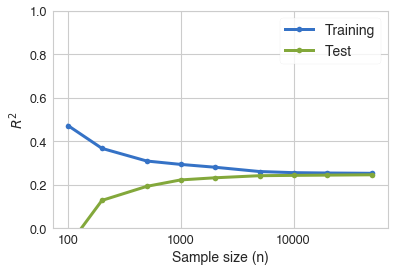

In [9]:
from matplotlib.ticker import ScalarFormatter

train_mean = train_scores.mean(1)
test_mean = test_scores.mean(1)
plt.plot(sizes, train_mean, 'o-', label='Training', lw=3)
plt.plot(sizes, test_mean, 'o-', label='Test', lw=3);
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.grid(True, axis='y')
plt.legend(fontsize=14)
plt.ylim(0, 1)
plt.xlabel('Sample size (n)', fontsize=14)
plt.ylabel('$R^2$', fontsize=14);

Inspecting the relationship between the training and testing curves in the above plot can tell us several important things about the behavior of our estimator (in this case, ordinary least-squares regression). We already observed in section 2 that performance in the training set appears to decrease with sample size—at least in this particular case (this is not a general rule). At the time, we speculated that this trend was illusory—i.e., it's not that our estimator really gets worse as we give it more data, but that its propensity to overfit when sample size is small leads us to *think* it's performing better than it really is early on in the curve.

We can now confirm this hypothesis by looking at the performance of our estimator in the test data. In contrast to the training data, $R^2$ improves monotonically as the training dataset gets larger. This *is* a general rule: a model's out-of-sample performance should only get better as it's trained on more data.

Note also that a certain point, as sample size grows, the two lines will converge. This is an indication that we should consider increasing the flexibility of our model. The fact that our model performs no better in the training set than the test set means that we've stopped learning from our data. While overfitting is generally a bad thing, its presence does at least signal that we're still gaining new information, and can benefit from increasing the sample size.

# Training vs. test vs. validation : a note on nomenclature

Before moving on, a quick note on nomenclature: you will sometimes hear people talk about "validation" sets rather than (or in addition to) training and test sets. What this means depends on the context. In many cases, the terms test set and validation set are used interchangeably to refer to a new dataset independently of the one the model is trained on. But sometimes, the distinction between validation and test is important. In particular, it's common to set aside a "true" hold-out dataset in advance of any validation efforts. In such cases, the test dataset is the one we use to obtain our final, no-takesies-backsies estimate of performance. The validation dataset, by contrast, is technically part of the training data (in that we allow ourselves to use it to train the final model), but it's being used for validation. When we perform a cross-validation procedure on a training set, we call the hold-out folds the validation sets.

This kind of 3-way split of our data is an excellent way to operate, as it ensures that we're able to detect overfitting that occurs not only during model estimation, but also in the model selection process (e.g., if we "cross-validate" 100 models and then choose the one with the best cross-validated performance, we're still going to overfit to some degree, and performance in the test dataset will reveal this).

<div align="center" style="font-size: 12px;">
<img src="images/trainvaltest.png">
Image from <a href="https://medium.com/@hi.martinez/train-test-split-cross-validation-you-b87f662445e1">https://medium.com/@hi.martinez/train-test-split-cross-validation-you-b87f662445e1</a>
</div>